In [ ]:
!pip install cirq --quiet
!pip install qiskit --quiet

In [ ]:
import numpy as np
import random
import time
import itertools as itert
import matplotlib.pyplot as plt
import math
from qiskit import *
from qiskit.providers.jobstatus import JobStatus
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import MCMT
from qiskit.tools.monitor import job_monitor
%matplotlib inline

Berstein Vazirani

In [ ]:
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def runAndPrint(n, uf_gate, verbose):
    rv_qr = list()
    for index in range(n):
        rv_qr.append(index)
    rv_qr.reverse()

    # Time taken by program needs to be checked.
    start = time.time()
    # Defining start of Cirq program
    quantum_register = QuantumRegister(n)
    classical_register = ClassicalRegister(n - 1)
    quantum_circuit = QuantumCircuit(quantum_register, classical_register)

    # setting last qubit to 1
    quantum_circuit.x(quantum_register[-1])
    
    # adding Hadamard gates to all qubits
    for i in range(0, n):
        quantum_circuit.h(quantum_register[i])
    
    # adding Uf gate
    quantum_circuit.unitary(uf_gate, rv_qr)
    
    # helper bit does not require H gate. Result is treated as trash/ garbage    
    for i in range(0, n-1):
        quantum_circuit.h(quantum_register[i])        
    
    # measurements
    quantum_circuit.measure(quantum_register[0:n-1], classical_register)
       
    mid = time.time()

    num_shots = 100
    simulator = Aer.get_backend('aer_simulator')
    circ = transpile(quantum_circuit, simulator)
    sim_results = simulator.run(circ, shots = num_shots).result()

    end = time.time()

    IBMQ.save_account('b5bbcda1a0eff0449582c42c04c3e1339b7d6af1ab309ffd16a8c573da617096454904a5983830ad7cfe7c2f554214b07ae5b642a9603d66dd91404a6cbb5db2')
    provider = IBMQ.load_account()

    backend = provider.backend.ibmq_quito
    transpiled = transpile(quantum_circuit, backend)
    job = backend.run(transpiled, shots = num_shots)

    result = backend.retrieve_job(job.job_id()).result()

    if verbose:
        print("Circuit used to solve problem: ")
        print(quantum_circuit)
    
        print("IBM Results: ")
        delayed_counts = result.get_counts()
        print(delayed_counts)
        plt.bar(delayed_counts.keys(), delayed_counts.values(), color='b')
        plt.show()

        frequencies = sim_results.get_counts(circ)
        print('Simulated results:\n{}'.format(frequencies))
        plt.bar(frequencies.keys(), frequencies.values(), color='r')
        plt.show()

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for simulation: ", end - mid)
        print("Time taken by execution: ", result.time_taken)

    return (mid - start, end - mid, result.time_taken)

def decimalToBinary(x, n):
    s = bin(x).replace("0b", "")
    currsize = len(s)
    ans = '0' * (n - currsize)
    ans += s
    return ans

def getFx(x, a, b, n):
    # Last bit is the helper qubit
    xb = decimalToBinary(x, n+1)
    ab = decimalToBinary(a, n)

    # Add b
    val = b

    # Perform a.x
    for i in range(n):
        val += int(xb[i]) * int(ab[i])
    
    return (val % 2)

def createUfBV(n, a, b, verbose = True):
    ufMatrix = np.zeros((2**n,2**n))

    for i in range(2 ** n):
        val = getFx(i, a, b, n - 1)
        if val == 1:
            if i % 2 == 0:
                ufMatrix[i+1][i] = 1
            else:
                ufMatrix[i-1][i] = 1
        else:
            ufMatrix[i][i] = 1

    if verbose:
        print("Matrix Uf:")
        print(ufMatrix)

    return Operator(ufMatrix)

def runMainCircuitBV(n = 0, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)

    n = n + 1

    b = np.random.randint(low = 0, high = 2)
    a = np.random.randint(low = 0, high = 2**(n-1))

    if verbose:
        # Qiskit prints it reverse
        print('a: ', decimalToBinary(a, n - 1)[::-1])
        print('b: ', b)

    uf_gate = createUfBV(n, a, b, verbose)

    bval = getFx(0, a, b, n)

    if verbose:
        print('Expected b: ', bval)

    return runAndPrint(n, uf_gate, verbose)

Correctness Tests:

configrc.store_credentials:WARNING:2022-03-17 01:01:10,484: Credentials already present. Set overwrite=True to overwrite.


Input Length:  1
a:  1
b:  0
Matrix Uf:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Expected b:  0


ibmqfactory.load_account:WARNING:2022-03-17 01:01:10,691: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
         ┌───┐     ┌──────────┐┌───┐┌─┐
q1884_0: ┤ H ├─────┤1         ├┤ H ├┤M├
         ├───┤┌───┐│  Unitary │└───┘└╥┘
q1884_1: ┤ X ├┤ H ├┤0         ├──────╫─
         └───┘└───┘└──────────┘      ║ 
  c13: 1/════════════════════════════╩═
                                     0 
IBM Results: 
{'0': 8, '1': 92}


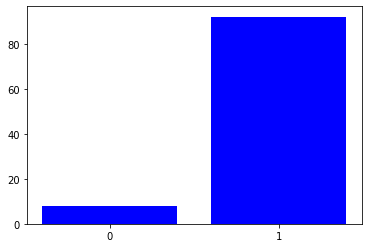

Simulated results:
{'1': 100}


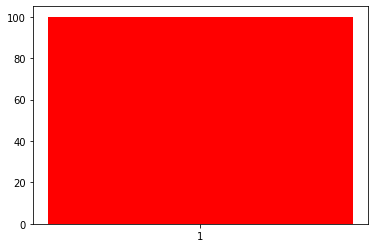

Time taken to create circuit:  0.001073598861694336
Time taken for simulation:  0.04223895072937012
Time taken by execution:  2.718953847885132


(0.001073598861694336, 0.04223895072937012, 2.718953847885132)

In [ ]:
runMainCircuitBV(1)

configrc.store_credentials:WARNING:2022-03-17 01:06:23,745: Credentials already present. Set overwrite=True to overwrite.


Input Length:  2
a:  10
b:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Expected b:  1


ibmqfactory.load_account:WARNING:2022-03-17 01:06:24,042: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
         ┌───┐     ┌──────────┐┌───┐┌─┐   
q1923_0: ┤ H ├─────┤2         ├┤ H ├┤M├───
         ├───┤     │          │├───┤└╥┘┌─┐
q1923_1: ┤ H ├─────┤1 Unitary ├┤ H ├─╫─┤M├
         ├───┤┌───┐│          │└───┘ ║ └╥┘
q1923_2: ┤ X ├┤ H ├┤0         ├──────╫──╫─
         └───┘└───┘└──────────┘      ║  ║ 
  c14: 2/════════════════════════════╩══╩═
                                     0  1 
IBM Results: 
{'00': 18, '01': 7, '10': 62, '11': 13}


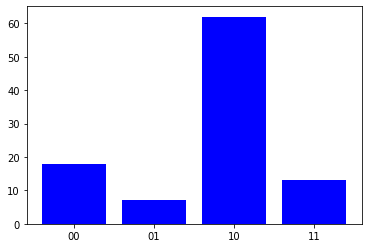

Simulated results:
{'10': 100}


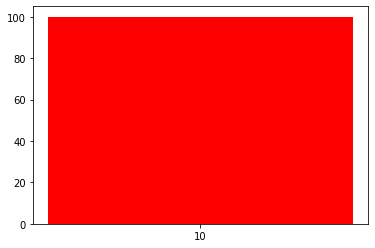

Time taken to create circuit:  0.001691579818725586
Time taken for simulation:  0.05467796325683594
Time taken by execution:  4.005243539810181


(0.001691579818725586, 0.05467796325683594, 4.005243539810181)

In [ ]:
runMainCircuitBV(2)

Input Length:  3
a:  101
b:  0
Matrix Uf:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Expected b:  0


configrc.store_credentials:WARNING:2022-03-17 01:18:24,259: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 01:18:24,457: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
         ┌───┐     ┌──────────┐┌───┐┌─┐      
q1989_0: ┤ H ├─────┤3         ├┤ H ├┤M├──────
         ├───┤     │          │├───┤└╥┘┌─┐   
q1989_1: ┤ H ├─────┤2         ├┤ H ├─╫─┤M├───
         ├───┤     │  Unitary │├───┤ ║ └╥┘┌─┐
q1989_2: ┤ H ├─────┤1         ├┤ H ├─╫──╫─┤M├
         ├───┤┌───┐│          │└───┘ ║  ║ └╥┘
q1989_3: ┤ X ├┤ H ├┤0         ├──────╫──╫──╫─
         └───┘└───┘└──────────┘      ║  ║  ║ 
  c15: 3/════════════════════════════╩══╩══╩═
                                     0  1  2 
IBM Results: 
{'000': 8, '001': 16, '010': 9, '011': 6, '100': 29, '101': 23, '110': 4, '111': 5}


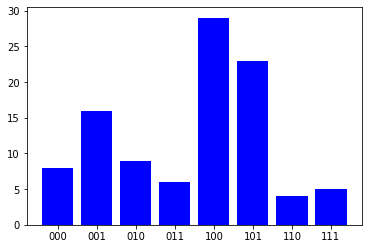

Simulated results:
{'101': 100}


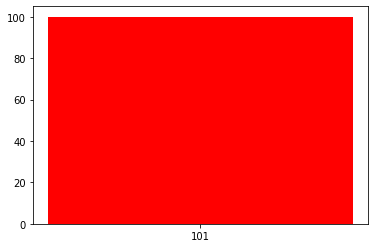

Time taken to create circuit:  0.005766630172729492
Time taken for simulation:  0.08197307586669922
Time taken by execution:  4.739461183547974


(0.005766630172729492, 0.08197307586669922, 4.739461183547974)

In [ ]:
runMainCircuitBV(3)

Input Length:  4
a:  1011
b:  1
Matrix Uf:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Expected b:  1


configrc.store_credentials:WARNING:2022-03-17 01:29:14,311: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 01:29:14,643: Credentials are already in use. The existing account in the session will be replaced.


Circuit used to solve problem: 
         ┌───┐     ┌──────────┐┌───┐┌─┐         
q2085_0: ┤ H ├─────┤4         ├┤ H ├┤M├─────────
         ├───┤     │          │├───┤└╥┘┌─┐      
q2085_1: ┤ H ├─────┤3         ├┤ H ├─╫─┤M├──────
         ├───┤     │          │├───┤ ║ └╥┘┌─┐   
q2085_2: ┤ H ├─────┤2 Unitary ├┤ H ├─╫──╫─┤M├───
         ├───┤     │          │├───┤ ║  ║ └╥┘┌─┐
q2085_3: ┤ H ├─────┤1         ├┤ H ├─╫──╫──╫─┤M├
         ├───┤┌───┐│          │└───┘ ║  ║  ║ └╥┘
q2085_4: ┤ X ├┤ H ├┤0         ├──────╫──╫──╫──╫─
         └───┘└───┘└──────────┘      ║  ║  ║  ║ 
  c16: 4/════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3 
IBM Results: 
{'0000': 2, '0001': 2, '0010': 9, '0011': 4, '0100': 6, '0101': 4, '0110': 6, '0111': 3, '1000': 12, '1001': 5, '1010': 10, '1011': 4, '1100': 10, '1101': 6, '1110': 12, '1111': 5}


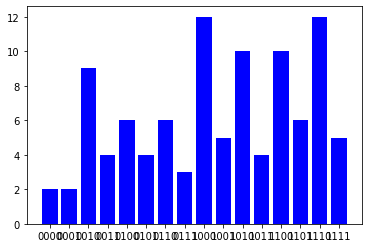

Simulated results:
{'1011': 100}


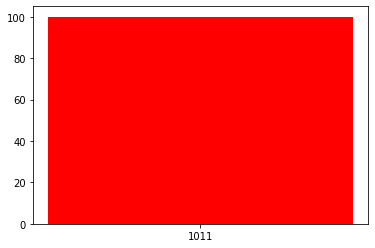

Time taken to create circuit:  0.003076314926147461
Time taken for simulation:  0.09604120254516602
Time taken by execution:  4.2626166343688965


(0.003076314926147461, 0.09604120254516602, 4.2626166343688965)

In [ ]:
runMainCircuitBV(4)

Time for various Uf for n = 4

configrc.store_credentials:WARNING:2022-03-17 00:13:03,131: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:13:03,593: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 00:22:13,404: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:22:13,698: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 00:25:03,574: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:25:04,249: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 00:32:43,145: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:32:43,347: Credentials are alread

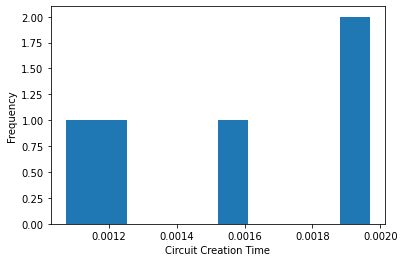

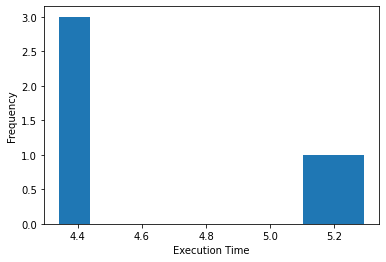

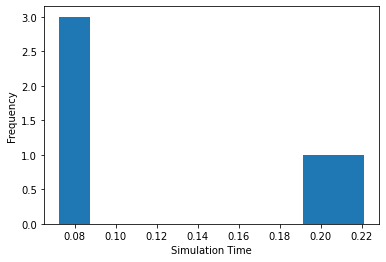

In [ ]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(5):
    (circuit, sim, execution) = runMainCircuitBV(4, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(sim)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Simulation Time')
plt.ylabel('Frequency')
plt.show() 

Effect of n on execution time

configrc.store_credentials:WARNING:2022-03-17 00:46:54,177: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:46:54,487: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 00:47:32,775: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:47:32,989: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 00:49:03,271: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:49:03,828: Credentials are already in use. The existing account in the session will be replaced.
configrc.store_credentials:WARNING:2022-03-17 00:56:23,681: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-03-17 00:56:24,000: Credentials are alread

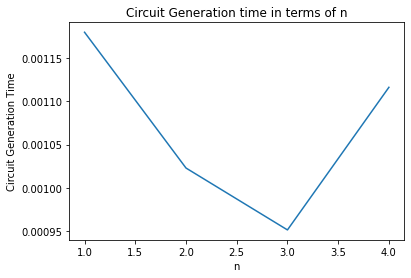

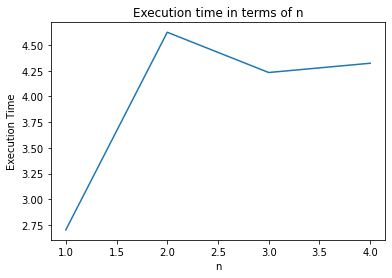

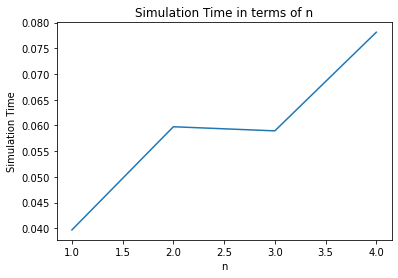

In [ ]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 5):
    (circuit, sim, execution) = runMainCircuitBV(n, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(sim)

x_axis = [1, 2, 3, 4]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Simulation Time in terms of n')
plt.ylabel('Simulation Time')
plt.xlabel('n')
plt.show() 

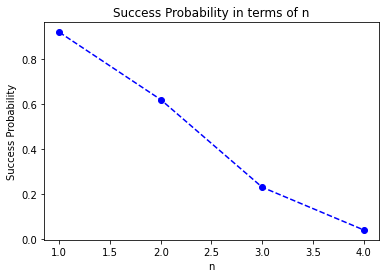

In [ ]:
import matplotlib.pyplot as plt
x_axis = [1, 2, 3, 4]
y_axis = [0.92, 0.62, 0.23, 0.04]
plt.plot(x_axis, y_axis, '--bo')
plt.title('Success Probability in terms of n')
plt.ylabel('Success Probability')
plt.xlabel('n')
plt.show() 